In [1]:
import os
os.environ['HF_HOME'] = '/om/user/ericjm/.cache/huggingface'
from typing import Dict, Union, Any, Mapping, Callable

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
import einops

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
)
from datasets import load_dataset

from tqdm.auto import tqdm
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def prune_by_attribution(
    model: nn.Module,
    train_dataloader,
    importance_threshold: float = 1e-7,
    attribution_batch_size: int = 4,
    num_attribution_batches: int = 4,
    save_pruned_model: bool = False,
    output_dir: str = "./pruned_model",
):
    device = next(model.parameters()).device
    neuron_to_avg_effect = {}

    def compute_neuron_importances():
        # print(
        #     f"Processing {num_attribution_batches} of size {attribution_batch_size} batches for attribution..."
        # )
        for batch_idx, inputs in enumerate(train_dataloader):
            # print(f"Processing batch {batch_idx + 1}/{num_attribution_batches}")
            if batch_idx >= num_attribution_batches:
                break
            inputs = _prepare_inputs(inputs)

            # Compute the effect of each neuron on the loss
            _, cache, grad_cache = get_cache_fwd_and_bwd(model, inputs)

            for layer_idx, layer in enumerate(model.model.layers):
                for mat_name in ["gate_proj", "up_proj", "down_proj"]:
                    matrix = getattr(layer.mlp, mat_name)
                    cache_key = id(matrix)

                    neuron_acts = cache.cache_dict[cache_key]
                    neuron_grads = grad_cache.cache_dict[cache_key]

                    for neuron_idx in range(matrix.weight.shape[0]):
                        # takes element-wise product between neuron gradients and activations, sums over sequence dimension
                        neuron_effect = einops.einsum(
                            neuron_grads[:, :, neuron_idx],
                            neuron_acts[:, :, neuron_idx],
                            "batch seq, batch seq -> batch",
                        )
                        avg_neuron_effect = neuron_effect.mean().item()

                        cache_name = f"layer_{layer_idx}_{mat_name}"
                        if cache_name not in neuron_to_avg_effect:
                            neuron_to_avg_effect[cache_name] = {}

                        if neuron_idx not in neuron_to_avg_effect[cache_name]:
                            neuron_to_avg_effect[cache_name][neuron_idx] = 0.0

                        neuron_to_avg_effect[cache_name][
                            neuron_idx
                        ] += avg_neuron_effect

        # Average the neuron effects over the batches
        for cache_name in neuron_to_avg_effect:
            for neuron_idx in neuron_to_avg_effect[cache_name]:
                neuron_to_avg_effect[cache_name][neuron_idx] /= num_attribution_batches

    def prune_neurons():
        total_neurons_pruned = 0
        total_neurons = 0

        for layer_idx in range(len(model.model.layers)):
            layer = model.model.layers[layer_idx]
            for mat_name in ["gate_proj", "up_proj", "down_proj"]:
                matrix = getattr(layer.mlp, mat_name)
                total_neurons += matrix.weight.shape[0]
                cache_name = f"layer_{layer_idx}_{mat_name}"

                neuron_effects = neuron_to_avg_effect[cache_name]

                # Prune neurons with absolute effect below threshold
                neurons_to_prune = [
                    neuron
                    for neuron, effect in neuron_effects.items()
                    if abs(effect) < importance_threshold
                ]

                # Create mask
                output_mask = torch.ones(
                    matrix.weight.shape[0], device=matrix.weight.device
                )
                output_mask[neurons_to_prune] = 0

                num_pruned = (output_mask == 0).sum().item()
                total_neurons_pruned += num_pruned

                full_mask = output_mask.unsqueeze(1).expand_as(matrix.weight)
                prune.custom_from_mask(matrix, name="weight", mask=full_mask)

            # print(f"Layer {layer_idx}:")
        #     print(
        #         f"- Pruning {num_pruned} out of {layer.mlp.gate_proj.weight.shape[0]} neurons"
        #     )
        # print(
        #     f"Total neurons pruned across all layers: {total_neurons_pruned} / {total_neurons} ({total_neurons_pruned/total_neurons:.2%})"
        # )
        return total_neurons_pruned, total_neurons

    def _prepare_inputs(
        inputs: Dict[str, Union[torch.Tensor, Any]]
    ) -> Dict[str, Union[torch.Tensor, Any]]:
        if isinstance(inputs, Mapping):
            return type(inputs)({k: _prepare_input(v) for k, v in inputs.items()})

    def _prepare_input(data: Union[torch.Tensor, Any]) -> Union[torch.Tensor, Any]:
        if isinstance(data, Mapping):
            return type(data)({k: _prepare_input(v) for k, v in data.items()})
        elif isinstance(data, (tuple, list)):
            return type(data)(_prepare_input(v) for v in data)
        elif isinstance(data, torch.Tensor):
            kwargs = {"device": device}
            return data.to(**kwargs)
        return data

    def get_cache_fwd_and_bwd(model, tokens):
        cache = {}
        grad_cache = {}

        def forward_hook(module, input, output):
            cache[id(module)] = output.detach()
            return output

        def backward_hook(module, grad_input, grad_output):
            grad_cache[id(module)] = grad_output[0].detach()
            return grad_input

        # Register hooks for MLP layers
        for name, module in model.named_modules():
            if "mlp" in name:
                module.register_forward_hook(forward_hook)
                module.register_full_backward_hook(backward_hook)

        # Forward and backward pass
        outputs = model(**tokens)
        loss = outputs.loss
        loss.backward()

        class SimpleCache:
            def __init__(self, cache_dict):
                self.cache_dict = cache_dict

            def __getitem__(self, key):
                return self.cache_dict[key]

        return (
            loss.item(),
            SimpleCache(cache),
            SimpleCache(grad_cache),
        )

    # Start the pruning process
    compute_neuron_importances()
    # prune_neurons()
    total_neurons_pruned, total_neurons = prune_neurons()

    if save_pruned_model:
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        print(f"Pruned model saved to {output_dir}")
    
    return total_neurons_pruned, total_neurons

def prune_by_weight_norm(
    model: nn.Module,
    pruning_threshold: float,
    save_pruned_model: bool = False,
    output_dir: str = "./pruned_model",
):
    total_neurons_pruned = 0
    total_neurons = 0

    for i, layer in enumerate(model.model.layers):
        gate_proj = layer.mlp.gate_proj
        up_proj = layer.mlp.up_proj
        down_proj = layer.mlp.down_proj

        total_neurons += gate_proj.weight.shape[0]
        L2 = torch.sqrt(
            gate_proj.weight.pow(2).sum(dim=1)
            + up_proj.weight.pow(2).sum(dim=1)
            + down_proj.weight.pow(2).sum(dim=0)
        )
        # L2 Shape: torch.Size([8192])

        # Mask neurons based on the L2 norm of the contributing parameters
        output_mask = L2 >= pruning_threshold
        num_pruned = (~output_mask).sum().item()
        total_neurons_pruned += num_pruned

        mask = output_mask.unsqueeze(1).expand_as(gate_proj.weight)
        prune.custom_from_mask(gate_proj, name="weight", mask=mask)
        prune.custom_from_mask(up_proj, name="weight", mask=mask)
        prune.custom_from_mask(down_proj, name="weight", mask=mask.T)

    #     print(f"Layer {i}:")
    #     print(f"- Pruned {num_pruned} out of {len(output_mask)} neurons")

    # print(
    #     f"Total neurons pruned across all layers: {total_neurons_pruned} / {total_neurons} ({total_neurons_pruned/total_neurons:.2%})"
    # )

    if save_pruned_model:
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        print(f"Pruned model saved to {output_dir}")
    return total_neurons_pruned, total_neurons


def prepare_data_for_pruning(
    dataset_name: str,
    model_name: str,
    max_length: int,
    batch_size: int,
    num_samples: int = 1000,
):
    dataset = load_dataset(
        dataset_name, languages=["Python"], split="train", streaming=True
    )
    attribution_dataset = dataset.take(num_samples)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    def prepare_dataset(dataset, tokenizer, max_length):
        def tokenize_function(examples):
            return tokenizer(
                examples["code"],
                truncation=True,
                max_length=max_length,
            )

        tokenized_dataset = dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=dataset.column_names,
        )
        return tokenized_dataset

    attribution_tokenized = prepare_dataset(
        attribution_dataset, tokenizer, max_length=max_length
    )
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    attribution_dataloader = DataLoader(
        attribution_tokenized, batch_size=batch_size, collate_fn=data_collator
    )
    return attribution_dataloader

In [ ]:
def prunability(mlp, x, y, loss_fn, effect_thresholds=[1e-10, 1e-8, 1e-6, 1e-4, 1e-2], loss_threshold=1e-2):
    """ Computes the number of neurons that can be pruned from the MLP while 
    keeping the loss below a certain threshold on the given dataset.

    This function first estimates the effects of ablating each neuron with
    attribution patching. Then we prune neurons with effect below varying 
    thresholds and recompute the loss, checking that it remains below the
    `loss_threshold`.
    """
    mlp_n = NNsight(mlp)
    effect_thresholds = sorted(effect_thresholds)
    layer_names = [name for name, module in mlp.named_children() if name.startswith("act")]

    # compute effects
    with mlp_n.trace(x):
        activations = {}
        grads = {}
        for name in layer_names:
            activations[name] = getattr(mlp_n, name).output.save()
            grads[name] = getattr(mlp_n, name).output.grad.save()
        y_pred = mlp_n.output
        loss = loss_fn(y_pred, y)
        loss.backward()
    effects = {}
    for name in layer_names:
        effects[name] = torch.mean(activations[name] * grads[name], dim=0)
    
    # prune neurons and check loss
    pruning_results = {}
    for threshold in effect_thresholds:
        with mlp_n.trace(x):
            for name in layer_names:
                getattr(mlp_n, name).output[:, effects[name].abs() < threshold] = 0.0
            y_pred = mlp_n.output.save()
        loss = loss_fn(y_pred, y).item()
        if loss > loss_threshold:
            break
        pruning_results[threshold] = {
            "loss": loss,
            "neurons_kept": {
                name: (effects[name].abs() >= threshold).nonzero().flatten().tolist()
                for name in layer_names
            }
        }
    
    # free memory
    del mlp_n
    del activations
    del grads
    del y_pred
    del effects

    if not pruning_results:
        return {
           "loss": loss_fn(mlp.forward(x), y).item(),
              "neurons_kept": {
                name: list(range(getattr(mlp, name.replace("act", "fc")).out_features))
                for name in layer_names
              } 
        }
    # last acceptable threshold
    last_threshold = max(pruning_results.keys())
    return pruning_results[last_threshold]

In [4]:
model_copy = AutoModelForCausalLM.from_pretrained(
    "model_copy",
    torch_dtype=torch.float32,  # or float16 if your GPU supports it
    device_map="auto"           # could also specify device like "cuda:0"
) 

In [6]:
model_copy.model.layers[0].mlp.act_fn

SiLU()

In [2]:
from nnsight import NNsight

In [13]:
model = AutoModelForCausalLM.from_pretrained(
    "model_copy",
    torch_dtype=torch.float32,  # or float16 if your GPU supports it
    device_map="auto"           # could also specify device like "cuda:0"
)

In [15]:
model = NNsight(model)

In [30]:
model_name = "NousResearch/Llama-3.2-1B"
batch_size = 4
n_batches = 4

test_dataloader = prepare_data_for_pruning(
    dataset_name="codeparrot/github-code",
    model_name=model_name,
    max_length=512,
    batch_size=batch_size,
    num_samples=n_batches * batch_size
)

attributions = {}
num_attribution_batches = 4
for batch_idx, inputs in enumerate(test_dataloader):
    if batch_idx >= num_attribution_batches:
        break
    with model.trace(**inputs):
        activations = {}
        grads = {}
        for layeri in range(len(model.model.layers)):
            activations[layeri] = model.model.layers[layeri].mlp.act_fn.output.save()
            grads[layeri] = model.model.layers[layeri].mlp.act_fn.output.grad.save()
        outputs = model.output
        loss = outputs.loss
        loss.backward()
        # for layeri in range(len(model.model.layers)):
        #     attributions[layeri] = activations[layeri] * grads[layeri]

TypeError: 'str' object is not callable

In [ ]:
def prune_by_attribution_eric(
    model: nn.Module,
    train_dataloader,
    importance_threshold: float = 1e-7,
    attribution_batch_size: int = 4,
    num_attribution_batches: int = 4,
    save_pruned_model: bool = False,
    output_dir: str = "./pruned_model"):
    """
    Prune MLP neurons according to attribution scores. Uses nnsight to get
    gradient attribution scores.
    """
    model = NNsight(model)
    attributions = {}
    for batch_idx, inputs in enumerate(train_dataloader):
        if batch_idx >= num_attribution_batches:
            break
        with model.trace(**inputs):
            activations = {}
            grads = {}
            for layeri in range(len(model.model.layers)):
                activations[layeri] = model.model.model.layers[layeri].mlp.act_fn.output.save()
                grads[layeri] = model.model.model.layers[layeri].mlp.act_fn.output.grad.save()
            outputs = model.output
            loss = outputs.loss
            loss.backward()
            for layeri in range(len(model.model.layers)):
                attributions[layeri] = activations[layeri] * grads[layeri]



        # inputs = _prepare_inputs(inputs)
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        for name, module in model.named_children():
            if name.startswith("act"):
                attributions[name] = module.output.grad
    with model.trace():
        for batch_idx, inputs in enumerate(train_dataloader):
            if batch_idx >= num_attribution_batches:
                break
            # inputs = _prepare_inputs(inputs)
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()



In [4]:
model_name = "NousResearch/Llama-3.2-1B"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,  # or float16 if your GPU supports it
    device_map="auto"           # could also specify device like "cuda:0"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

Text(0, 0.5, 'count')

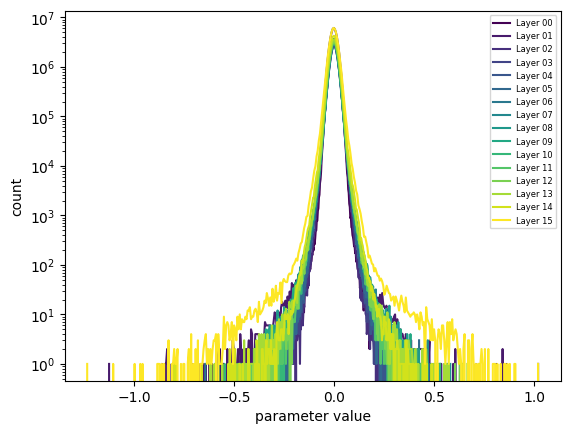

In [4]:
colors = plt.cm.viridis(np.linspace(0, 1, 16))
for i in range(16):
    values = [
        model.model.layers[i].mlp.gate_proj.weight.flatten().detach().cpu().numpy(),
        model.model.layers[i].mlp.up_proj.weight.flatten().detach().cpu().numpy(),
        model.model.layers[i].mlp.down_proj.weight.flatten().detach().cpu().numpy(),
    ]
    values = np.concatenate(values)
    hist, bin_edges = np.histogram(values, bins=400)
    plt.plot(bin_edges[:-1], hist, color=colors[i], label=f"Layer {i:02d}")
plt.yscale('log')
plt.legend(prop={'size': 6})
plt.xlabel("parameter value")
plt.ylabel("count")

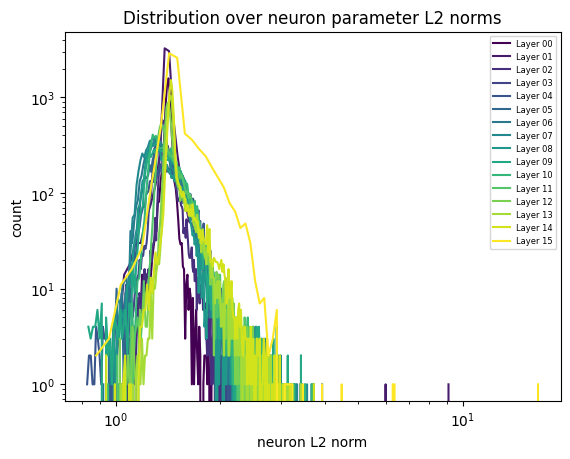

In [5]:
colors = plt.cm.viridis(np.linspace(0, 1, 16))
for layeri in range(len(model.model.layers)):
    gate_proj = model.model.layers[layeri].mlp.gate_proj.weight # (4x, x)
    up_proj = model.model.layers[layeri].mlp.up_proj.weight     # (4x, x)
    down_proj = model.model.layers[layeri].mlp.down_proj.weight # (x, 4x)
    L2 = torch.sqrt(
        gate_proj.pow(2).sum(dim=1) + \
        up_proj.pow(2).sum(dim=1) + \
        down_proj.pow(2).sum(dim=0)
    )
    neuron_l2s = L2.detach().cpu().numpy()
    hist, bin_edges = np.histogram(neuron_l2s, bins=200)
    plt.plot(bin_edges[:-1], hist, color=colors[layeri], label=f"Layer {layeri:02d}")
plt.yscale('log')
plt.xlabel("neuron L2 norm")
plt.ylabel("count")
plt.title("Distribution over neuron parameter L2 norms")
plt.legend(prop={'size': 6})
plt.xscale('log')

In [9]:
n_batches = 32
batch_size = 32

test_dataloader = prepare_data_for_pruning(
    dataset_name="codeparrot/github-code",
    model_name=model_name,
    max_length=512,
    batch_size=batch_size,
    num_samples=n_batches * batch_size
)

losses = []
with torch.no_grad():
    for batch in tqdm(islice(test_dataloader, n_batches), total=n_batches):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        del batch
        losses.append(outputs.loss.item())
    loss_baseline, std_baseline = np.mean(losses), np.std(losses)

  0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
print(f"Mean loss: {loss_baseline:.4f} ± {std_baseline/len(losses):.4f}")

Mean loss: 1.2864 ± 0.0032


In [11]:
# copy model via the saving and loading trick
# model.save_pretrained("model_copy")

## Prune by weight norm

In [14]:
threshold = 1.3
with torch.no_grad():
    model_copy = AutoModelForCausalLM.from_pretrained(
        "model_copy",
        torch_dtype=torch.float32,  # or float16 if your GPU supports it
        device_map="auto"           # could also specify device like "cuda:0"
    )

    neurons_pruned, total_neurons = prune_by_weight_norm(model_copy, pruning_threshold=threshold)
    print(f"Pruned {neurons_pruned} out of {total_neurons} neurons ({neurons_pruned/total_neurons:.2%})")

    n_batches = 8
    batch_size = 32

    test_dataloader = prepare_data_for_pruning(
        dataset_name="codeparrot/github-code",
        model_name=model_name,
        max_length=512,
        batch_size=batch_size,
        num_samples=n_batches * batch_size
    )

    losses = []
    for batch in tqdm(islice(test_dataloader, n_batches), total=n_batches):
        batch = {k: v.to(model_copy.device) for k, v in batch.items()}
        outputs = model_copy(**batch)
        del batch
        losses.append(outputs.loss.item())
    loss, std = np.mean(losses), np.std(losses)
print(f"Mean loss: {loss:.4f} ± {std/len(losses):.4f}")

Pruned 17041 out of 131072 neurons (13.00%)


  0%|          | 0/8 [00:00<?, ?it/s]

Mean loss: 2.4876 ± 0.0135


In [30]:
thresholds = [0.9, 0.95, 1.0, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5]
pruned_losses = []
pruned_neuron_stats = []
with torch.no_grad():
    for threshold in tqdm(thresholds):
        model_copy = AutoModelForCausalLM.from_pretrained(
            "model_copy",
            torch_dtype=torch.float32,  # or float16 if your GPU supports it
            device_map="auto"           # could also specify device like "cuda:0"
        )
        neurons_pruned, total_neurons = prune_by_weight_norm(
            model_copy, 
            pruning_threshold=threshold
        )
        pruned_neuron_stats.append((neurons_pruned, total_neurons))

        n_batches = 8
        batch_size = 32

        test_dataloader = prepare_data_for_pruning(
            dataset_name="codeparrot/github-code",
            model_name=model_name,
            max_length=512,
            batch_size=batch_size,
            num_samples=n_batches * batch_size
        )

        losses = []
        for batch in tqdm(islice(test_dataloader, n_batches), total=n_batches, leave=False):
            batch = {k: v.to(model_copy.device) for k, v in batch.items()}
            outputs = model_copy(**batch)
            del batch
            losses.append(outputs.loss.item())
        loss, std = np.mean(losses), np.std(losses)
        pruned_losses.append((loss, std))
        

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0, 0.5, 'Mean loss')

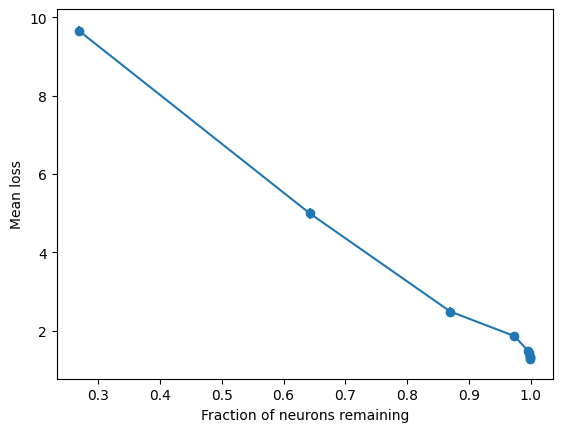

In [33]:
# plot plot with error bars
pruned_ls, pruned_stds = zip(*pruned_losses)
neurons_pruned, total_neurons = zip(*pruned_neuron_stats)
frac_neurons_remaining = [1 - n/t for n, t in zip(neurons_pruned, total_neurons)]
plt.errorbar(frac_neurons_remaining, pruned_ls, yerr=pruned_stds, fmt='o-')
plt.xlabel("Fraction of neurons remaining")
plt.ylabel("Mean loss on Python documents")

In [21]:
model_regularized = AutoModelForCausalLM.from_pretrained(
    "/om2/user/ericjm/narrow/experiments/tuneprune5/lambda_0.0005/checkpoint-30000",
    torch_dtype=torch.float32,  # or float16 if your GPU supports it
    device_map="auto"           # could also specify device like "cuda:0"
)

In [25]:
# save a copy of model_regularized
model_regularized.save_pretrained("model_regularized_copy")

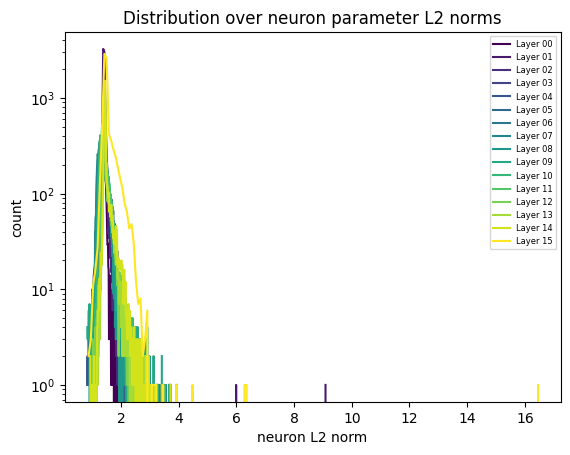

In [23]:
colors = plt.cm.viridis(np.linspace(0, 1, 16))
for layeri in range(len(model.model.layers)):
    gate_proj = model.model.layers[layeri].mlp.gate_proj.weight # (4x, x)
    up_proj = model.model.layers[layeri].mlp.up_proj.weight     # (4x, x)
    down_proj = model.model.layers[layeri].mlp.down_proj.weight # (x, 4x)
    L2 = torch.sqrt(
        gate_proj.pow(2).sum(dim=1) + \
        up_proj.pow(2).sum(dim=1) + \
        down_proj.pow(2).sum(dim=0)
    )
    neuron_l2s = L2.detach().cpu().numpy()
    hist, bin_edges = np.histogram(neuron_l2s, bins=200)
    plt.plot(bin_edges[:-1], hist, color=colors[layeri], label=f"Layer {layeri:02d}")
plt.yscale('log')
plt.xlabel("neuron L2 norm")
plt.ylabel("count")
plt.title("Distribution over neuron parameter L2 norms")
plt.legend(prop={'size': 6})
# plt.xscale('log')

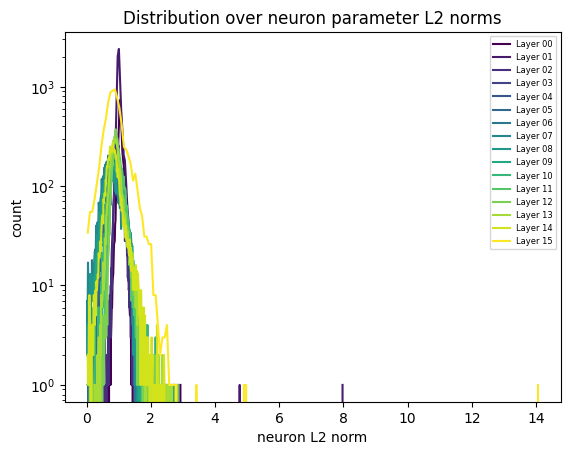

In [24]:
colors = plt.cm.viridis(np.linspace(0, 1, 16))
for layeri in range(len(model_regularized.model.layers)):
    gate_proj = model_regularized.model.layers[layeri].mlp.gate_proj.weight # (4x, x)
    up_proj = model_regularized.model.layers[layeri].mlp.up_proj.weight     # (4x, x)
    down_proj = model_regularized.model.layers[layeri].mlp.down_proj.weight # (x, 4x)
    L2 = torch.sqrt(
        gate_proj.pow(2).sum(dim=1) + \
        up_proj.pow(2).sum(dim=1) + \
        down_proj.pow(2).sum(dim=0)
    )
    neuron_l2s = L2.detach().cpu().numpy()
    hist, bin_edges = np.histogram(neuron_l2s, bins=200)
    plt.plot(bin_edges[:-1], hist, color=colors[layeri], label=f"Layer {layeri:02d}")
plt.yscale('log')
plt.xlabel("neuron L2 norm")
plt.ylabel("count")
plt.title("Distribution over neuron parameter L2 norms")
plt.legend(prop={'size': 6})
# plt.xscale('log')

In [34]:
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
pruned_losses_regularized = []
pruned_neuron_stats_regularized = []
with torch.no_grad():
    for threshold in tqdm(thresholds):
        model_copy = AutoModelForCausalLM.from_pretrained(
            "model_regularized_copy",
            torch_dtype=torch.float32,  # or float16 if your GPU supports it
            device_map="auto"           # could also specify device like "cuda:0"
        )
        neurons_pruned, total_neurons = prune_by_weight_norm(
            model_copy, 
            pruning_threshold=threshold
        )
        pruned_neuron_stats_regularized.append((neurons_pruned, total_neurons))

        n_batches = 8
        batch_size = 32

        test_dataloader = prepare_data_for_pruning(
            dataset_name="codeparrot/github-code",
            model_name=model_name,
            max_length=512,
            batch_size=batch_size,
            num_samples=n_batches * batch_size
        )

        losses = []
        for batch in tqdm(islice(test_dataloader, n_batches), total=n_batches, leave=False):
            batch = {k: v.to(model_copy.device) for k, v in batch.items()}
            outputs = model_copy(**batch)
            del batch
            losses.append(outputs.loss.item())
        loss, std = np.mean(losses), np.std(losses)
        pruned_losses_regularized.append((loss, std))
       

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

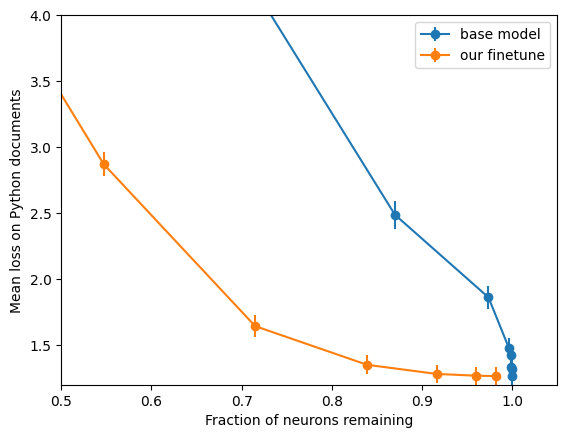

In [39]:
# plot plot with error bars
pruned_ls, pruned_stds = zip(*pruned_losses)
neurons_pruned, total_neurons = zip(*pruned_neuron_stats)
frac_neurons_remaining = [1 - n/t for n, t in zip(neurons_pruned, total_neurons)]
plt.errorbar(frac_neurons_remaining, pruned_ls, yerr=pruned_stds, fmt='o-', label="base model")

pruned_ls_regularized, pruned_stds_regularized = zip(*pruned_losses_regularized)
neurons_pruned_regularized, total_neurons_regularized = zip(*pruned_neuron_stats_regularized)
frac_neurons_remaining_regularized = [1 - n/t for n, t in zip(neurons_pruned_regularized, total_neurons_regularized)]
plt.errorbar(frac_neurons_remaining_regularized, pruned_ls_regularized, yerr=pruned_stds_regularized, fmt='o-', label="our finetune")

plt.xlabel("Fraction of neurons remaining")
plt.ylabel("Mean loss on Python documents")
plt.xlim(0.5, 1.05)
plt.ylim(1.2, 4)
plt.legend()

## Prune by attribution

In [9]:
pruned_losses = []
pruned_neuron_stats = []

model_copy = AutoModelForCausalLM.from_pretrained(
    "model_copy",
    torch_dtype=torch.float32,  # or float16 if your GPU supports it
    device_map="auto"           # could also specify device like "cuda:0"
)
# prune by attribution
n_batches = 4
batch_size = 4

test_dataloader = prepare_data_for_pruning(
    dataset_name="codeparrot/github-code",
    model_name=model_name,
    max_length=512,
    batch_size=batch_size,
    num_samples=n_batches * batch_size
)

total_neurons_pruned, total_neurons = prune_by_attribution(
    model_copy,
    test_dataloader,
    importance_threshold=1e-7,
    attribution_batch_size=batch_size,
    num_attribution_batches=n_batches,
    save_pruned_model=False,
)

In [10]:
print(f"Pruned {total_neurons_pruned} out of {total_neurons} neurons ({total_neurons_pruned/total_neurons:.2%})")

Pruned 1447 out of 294912 neurons (0.49%)


In [ ]:
pruned_losses = []
pruned_neuron_stats = []

model_name = "NousResearch/Llama-3.2-1B"
model_copy = AutoModelForCausalLM.from_pretrained(
    "model_copy",
    torch_dtype=torch.float32,  # or float16 if your GPU supports it
    device_map="auto"           # could also specify device like "cuda:0"
)
# prune by attribution
n_batches = 4
batch_size = 4

test_dataloader = prepare_data_for_pruning(
    dataset_name="codeparrot/github-code",
    model_name=model_name,
    max_length=512,
    batch_size=batch_size,
    num_samples=n_batches * batch_size
)

total_neurons_pruned, total_neurons = prune_by_attribution(
    model_copy,
    test_dataloader,
    importance_threshold=1e-7,
    attribution_batch_size=batch_size,
    num_attribution_batches=n_batches,
    save_pruned_model=False,
)

In [5]:
thresholds = [1e-8, 1e-7, 1e-6, 1e-5]
pruned_losses = []
pruned_neuron_stats = []

for threshold in tqdm(thresholds):

    model_name = "NousResearch/Llama-3.2-1B"
    model_copy = AutoModelForCausalLM.from_pretrained(
        "model_copy",
        torch_dtype=torch.float32,  # or float16 if your GPU supports it
        device_map="auto"           # could also specify device like "cuda:0"
    )
    # prune by attribution
    n_batches = 4
    batch_size = 4

    attribution_dataloader = prepare_data_for_pruning(
        dataset_name="codeparrot/github-code",
        model_name=model_name,
        max_length=512,
        batch_size=batch_size,
        num_samples=n_batches * batch_size
    )

    total_neurons_pruned, total_neurons = prune_by_attribution(
        model_copy,
        attribution_dataloader,
        importance_threshold=threshold,
        attribution_batch_size=batch_size,
        num_attribution_batches=n_batches,
        save_pruned_model=False,
    )

    # i think this will use the same samples to eval as we used to prune, which is not ideal
    test_dataloader = prepare_data_for_pruning(
        dataset_name="codeparrot/github-code",
        model_name=model_name,
        max_length=512,
        batch_size=batch_size,
        num_samples=n_batches * batch_size
    )

    losses = []
    for batch in tqdm(islice(test_dataloader, n_batches), total=n_batches, leave=False):
        batch = {k: v.to(model_copy.device) for k, v in batch.items()}
        outputs = model_copy(**batch)
        del batch
        losses.append(outputs.loss.item())
    loss, std_of_mean = np.mean(losses), np.std(losses) / np.sqrt(len(losses))
    pruned_losses.append((loss, std_of_mean))
    pruned_neuron_stats.append((total_neurons_pruned, total_neurons))

    # clean up memory
    del model_copy

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

<ErrorbarContainer object of 3 artists>

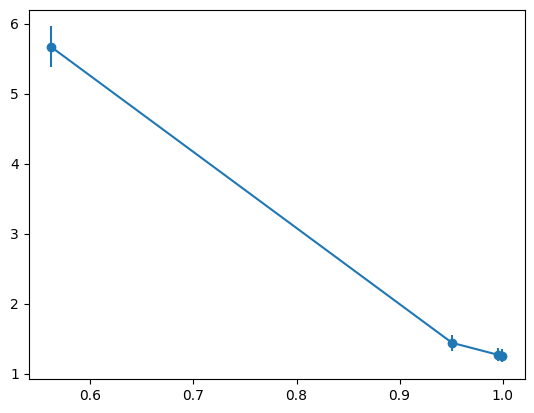

In [6]:
# plot results
pruned_ls, pruned_stds = zip(*pruned_losses)
neurons_pruned, total_neurons = zip(*pruned_neuron_stats)
frac_neurons_remaining = [1 - n/t for n, t in zip(neurons_pruned, total_neurons)]
plt.errorbar(frac_neurons_remaining, pruned_ls, yerr=pruned_stds, fmt='o-')

In [7]:
thresholds = [1e-8, 1e-7, 1e-6, 1e-5]
pruned_losses_regularized = []
pruned_neuron_stats_regularized = []

for threshold in tqdm(thresholds):

    model_name = "NousResearch/Llama-3.2-1B"
    model_copy = AutoModelForCausalLM.from_pretrained(
        "model_regularized_copy",
        torch_dtype=torch.float32,  # or float16 if your GPU supports it
        device_map="auto"           # could also specify device like "cuda:0"
    )
    # prune by attribution
    n_batches = 4
    batch_size = 4

    attribution_dataloader = prepare_data_for_pruning(
        dataset_name="codeparrot/github-code",
        model_name=model_name,
        max_length=512,
        batch_size=batch_size,
        num_samples=n_batches * batch_size
    )

    total_neurons_pruned, total_neurons = prune_by_attribution(
        model_copy,
        attribution_dataloader,
        importance_threshold=threshold,
        attribution_batch_size=batch_size,
        num_attribution_batches=n_batches,
        save_pruned_model=False,
    )

    # i think this will use the same samples to eval as we used to prune, which is not ideal
    test_dataloader = prepare_data_for_pruning(
        dataset_name="codeparrot/github-code",
        model_name=model_name,
        max_length=512,
        batch_size=batch_size,
        num_samples=n_batches * batch_size
    )

    losses = []
    for batch in tqdm(islice(test_dataloader, n_batches), total=n_batches, leave=False):
        batch = {k: v.to(model_copy.device) for k, v in batch.items()}
        outputs = model_copy(**batch)
        del batch
        losses.append(outputs.loss.item())
    loss, std_of_mean = np.mean(losses), np.std(losses) / np.sqrt(len(losses))
    pruned_losses_regularized.append((loss, std_of_mean))
    pruned_neuron_stats_regularized.append((total_neurons_pruned, total_neurons))

    # clean up memory
    del model_copy

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pruning based on attribution')

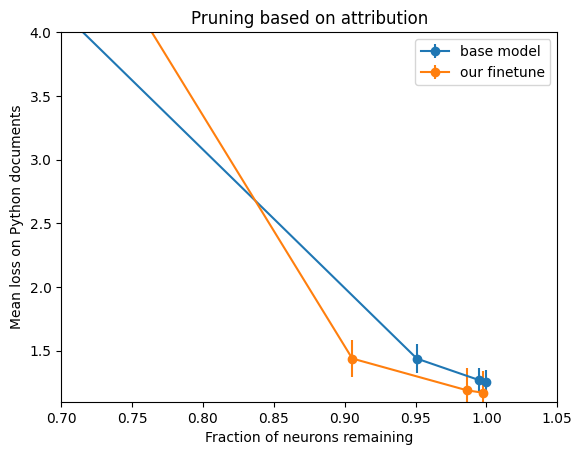

In [11]:
# plot plot with error bars
pruned_ls, pruned_stds = zip(*pruned_losses)
neurons_pruned, total_neurons = zip(*pruned_neuron_stats)
frac_neurons_remaining = [1 - n/t for n, t in zip(neurons_pruned, total_neurons)]
plt.errorbar(frac_neurons_remaining, pruned_ls, yerr=pruned_stds, fmt='o-', label="base model")

pruned_ls_regularized, pruned_stds_regularized = zip(*pruned_losses_regularized)
neurons_pruned_regularized, total_neurons_regularized = zip(*pruned_neuron_stats_regularized)
frac_neurons_remaining_regularized = [1 - n/t for n, t in zip(neurons_pruned_regularized, total_neurons_regularized)]
plt.errorbar(frac_neurons_remaining_regularized, pruned_ls_regularized, yerr=pruned_stds_regularized, fmt='o-', label="our finetune")

plt.xlabel("Fraction of neurons remaining")
plt.ylabel("Mean loss on Python documents")
plt.xlim(0.7, 1.05)
plt.ylim(1.1, 4)
plt.legend()
plt.title("Pruning based on attribution")

In [ ]:
thresholds = [0.9, 0.95, 1.0, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5]
pruned_losses = []
pruned_neuron_stats = []
with torch.no_grad():
    for threshold in tqdm(thresholds):
        model_copy = AutoModelForCausalLM.from_pretrained(
            "model_copy",
            torch_dtype=torch.float32,  # or float16 if your GPU supports it
            device_map="auto"           # could also specify device like "cuda:0"
        )
        neurons_pruned, total_neurons = prune_by_weight_norm(
            model_copy, 
            pruning_threshold=threshold
        )
        pruned_neuron_stats.append((neurons_pruned, total_neurons))

        n_batches = 8
        batch_size = 32

        test_dataloader = prepare_data_for_pruning(
            dataset_name="codeparrot/github-code",
            model_name=model_name,
            max_length=512,
            batch_size=batch_size,
            num_samples=n_batches * batch_size
        )

        losses = []
        for batch in tqdm(islice(test_dataloader, n_batches), total=n_batches, leave=False):
            batch = {k: v.to(model_copy.device) for k, v in batch.items()}
            outputs = model_copy(**batch)
            del batch
            losses.append(outputs.loss.item())
        loss, std = np.mean(losses), np.std(losses)
        pruned_losses.append((loss, std))
       

In [ ]:
# pruning_strategy = "attribution"
# save_pruned_model = True
# output_dir = "./pruned_models/llama_1B_checkpoint_1"

if pruning_strategy == "attribution":
    attribution_dataloader = prepare_data_for_pruning(
        dataset_name="codeparrot/github-code",
        model_name=model_name,
        max_length=512,
        batch_size=8,
    )
    prune_by_attribution(
        model=model,
        train_dataloader=attribution_dataloader,
        importance_threshold=1e-7,
        attribution_batch_size=2,
        num_attribution_batches=1,
        save_pruned_model=save_pruned_model,
        output_dir=output_dir,
    )
elif pruning_strategy == "weight_norm":
    pruning_threshold = 1.5
    prune_by_weight_norm(
        model=model,
        pruning_threshold=pruning_threshold,
        save_pruned_model=save_pruned_model,
        output_dir=output_dir,
    )
else:
    print("Invalid pruning strategy selected.")
